### Rappel Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator.
Installer ensuite deeplib avec la commande suivante:

In [2]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

  Cloning https://github.com/ulaval-damas/glo4030-labs.git to /tmp/pip-req-build-nwcb97l3
  Running command git clone --filter=blob:none --quiet https://github.com/ulaval-damas/glo4030-labs.git /tmp/pip-req-build-nwcb97l3
  Resolved https://github.com/ulaval-damas/glo4030-labs.git to commit c15d28e9050701a5555ed3f2f1421840cde5e113
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 67.6 MB/s eta 0:00:00
  Created wheel for deeplib: filename=deeplib-0.1-py3-none-any.whl size=10542 sha256=29f23496c8478038b4853eaf636cb9d4d660d9d4c41af3a33adcd788df3782e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-eoh6ibf0/wheels/9f/29/ed/25822e0088ad9c46b352ed51c58696b9d13fbc94e1db2ac759
Successfully built deeplib


# Laboratoire 2: Graphe computationnel, backprop et fonctions d'activation

In [3]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from deeplib.visualization import make_vizualization_autograd

##  Partie 1: Graphe computationnel et backprop
Cette section a pour but de vous familiariser avec les notions de graphe computationnel et de backpropagation, plus particulièrement leur implémentation PyTorch. Dans le dernier laboratoire, vous avez vu une version haut-niveau de l'entraînement de réseaux de neurones. À l'inverse, ce laboratoire a pour but de vous donner une intuition du fonctionnement interne de PyTorch.
### Tenseurs
La structure de données de base dans PyTorch est le `Tensor`. Cette structure de données est comparable au `ndarray` numpy, avec l'avantage que les calculs matriciels peuvent être effectués sur GPU. Le package `torch.Tensor` définit des matrices multidimensionnelles et les opérations sur celles-ci. Voici quelques exemples:

On peut créer un nouveau `Tensor` de dimension $3 \times 3$ sans initialisation avec `torch.Tensor()` ou `torch.empty()`. Cependant, les valeurs déjà présentes dans la mémoire allouée sont utilisées comme valeurs initiales et peuvent donc contenir des NaN.

In [24]:
print(torch.Tensor(3, 3))
print(torch.empty(3, 3))

tensor([[4.3895e+30, 4.3754e-41, 2.5129e-16],
        [0.0000e+00, 4.4842e-44, 0.0000e+00],
        [1.7937e-43, 0.0000e+00, 2.8434e-40]])
tensor([[4.3895e+30, 4.3754e-41, 4.3895e+30],
        [4.3754e-41, 4.4842e-44, 0.0000e+00],
        [1.7937e-43, 0.0000e+00, 6.7262e-44]])


Il est possible d'initialiser un `Tensor` avec des valeurs plus utiles, comme par exemple avec des valeurs de 0 ou 1, ou encore pour obtenir une matrice identité.

In [25]:
print(torch.zeros(3, 3))
print(torch.ones(3, 3))
print(torch.eye(3))

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


On peut également créer un `Tensor` à partir de données existantes fournies explicitement ou à partir de structures de `numpy`.

In [26]:
print(torch.tensor([1, 2, 3]))
a = np.array([0.1, 0.25, 0.5])
print(a, type(a))
a = torch.from_numpy(a)
print(a, type(a))
a = a.numpy()
print(a, type(a))

tensor([1, 2, 3])
[0.1  0.25 0.5 ] <class 'numpy.ndarray'>
tensor([0.1000, 0.2500, 0.5000], dtype=torch.float64) <class 'torch.Tensor'>
[0.1  0.25 0.5 ] <class 'numpy.ndarray'>


Il est souvent nécessaire d'initialiser un `Tensor` avec des valeurs aléatoires, comme par exemple selon une normale centrée à 0 et de variance 1.

In [27]:
a = torch.randn(3, 3)
print(a)
print(torch.mean(a))
print(torch.var(a))

tensor([[-1.2942,  0.9310,  1.4744],
        [ 1.6938, -0.4168, -0.3857],
        [ 0.2746,  0.2363,  2.0982]])
tensor(0.5124)
tensor(1.2597)


On peut également d'initialiser les valeurs d'un `Tensor` déjà existant avec des fonctions comme `normal_()` et `fill_()`. À noter, une méthode se terminant par un trait de soulignement (underscore) signifie que cette méthode fait une mutation du `Tensor`.

In [28]:
a, b = torch.empty(3, 3), torch.empty(3, 1)
print(a)
print(b)
a.normal_()
b.fill_(1)
print(a)
print(b)

tensor([[6.6861e-10, 0.0000e+00, 9.9584e-15],
        [0.0000e+00, 8.9683e-44, 0.0000e+00],
        [1.3452e-43, 0.0000e+00, 2.8433e-40]])
tensor([[1.3300e-15],
        [0.0000e+00],
        [0.0000e+00]])
tensor([[-1.3470, -0.7695, -0.4270],
        [ 1.8249, -0.3513,  0.1825],
        [-0.8036, -0.9542,  1.2309]])
tensor([[1.],
        [1.],
        [1.]])


Les opérations matricielles s'effectuent naturellement sur les `Tensor`.

In [29]:
print(a.matmul(b))
print(torch.matmul(a, b))

tensor([[-2.5435],
        [ 1.6561],
        [-0.5269]])
tensor([[-2.5435],
        [ 1.6561],
        [-0.5269]])


On peut facilement transférer un `Tensor` sur GPU (*Attention: une erreur est soulevée si on tente cette opération sur un ordinateur qui ne possède pas de carte graphique compatible avec les installations requises comme CUDA*). Les opérations sur ces `Tensor` seront alors exécutées sur GPU. On utilise la fonction [`.cuda()`](https://pytorch.org/docs/stable/tensors.html?highlight=cuda#torch.Tensor.cuda) pour envoyer un `Tensor` sur GPU et la fonction [`.cpu()`](https://pytorch.org/docs/stable/tensors.html?highlight=cpu#torch.Tensor.cpu) pour rapporter un `Tensor` vers le CPU.

In [30]:
a_gpu = a.cuda()
b_gpu = b.cuda()
print(a_gpu.matmul(b_gpu))
print(a_gpu.matmul(b_gpu).cpu())

tensor([[-2.5435],
        [ 1.6561],
        [-0.5269]], device='cuda:0')
tensor([[-2.5435],
        [ 1.6561],
        [-0.5269]])


##### Exercice
 - Corrigez la deuxième opération pour multiplier `a` avec `c_gpu` sur CPU.

In [31]:
c_gpu = a_gpu.matmul(b_gpu).cpu()
# TODO Corrigez le code suivant
print(a.matmul(c_gpu))

tensor([[ 2.3768],
        [-5.3194],
        [-0.1849]])


### Gradient et rétropropagation (backpropagation)

Grâce au package `torch.autograd`, il est possible d'automatiquement calculer la dérivée de fonctions calculées à partir d'opérations sur les tenseurs. PyTorch construit dynamiquement un graphe de calcul indiquant les liens de dépendance entre les tenseurs et les opérations, ce qui permet la backpropagation.

> **NOTE** Contrairement à des librairies comme Tensorflow où le graphe de calcul est statique, PyTorch recrée dynamique le graphe de calcul à chaque itération. Cela permet de modifier la structure du graphe dynamiquement avec du code Python. Par contre, cela rend la visualisation du graphe plus difficile.


On indique les tenseurs qu'on veut dériver avec `requires_grad=True` (par défaut à False) lors de l'initialisation,

In [32]:
x = torch.tensor(3., requires_grad=True)

ou encore en modifiant l'attribut `requires_grad` d'un `Tensor` existant.

In [33]:
x.requires_grad = False
print(x)
x.requires_grad = True
print(x)

tensor(3.)
tensor(3., requires_grad=True)


Le graphe de calcul est alors bâti au fur et à mesure que des opérations mathématiques sont appliquées aux tenseurs.

In [34]:
f = x ** 2

Chaque `Tensor` résultant d'une opération comporte un attribut `grad_fn` qui réfère à la `Fonction` (opération) qui l'a créé. Dans notre exemple nous avons utilisé une fonction puissance, par conséquent `grad_fn` de $f$ réfère à `PowBackward` correspondant à la fonction à utiliser pour la backprop (`Backward`) associée à la fonction puissance (`Pow` pour Power).

In [35]:
f

tensor(9., grad_fn=<PowBackward0>)

On obtient un graphe acyclique qui encode l'historique de calcul comportant les `Tensor` avec `requires_grad=True` et les `Fonction` appliqués sur ceux-ci. En utilisant la fonction `make_vizualization_autograd` de deeplib, on peut visualiser ce graphe où les `Fonction` sont représentées par un rectangle gris avec la valeur de `grad_fn` et les `Tensor` aillant `requires_grad=True` par un rectangle bleu comportant l'identifiant *Var* ainsi que leur attribut `size`. Dans cet exemple, le rectangle bleu réfère au `Tensor` $x$.

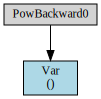

In [36]:
make_vizualization_autograd(f)

À la fin des calculs, on appelle la fonction `backward()` qui parcourt le graphe de calcul en sens inverse et calcule le gradient de la fonction $f$ selon chacune des variables du graphe

In [37]:
f.backward()

Après avoir exécuté la fonction backward(), l'attribut grad des tenseurs impliqués dans le calcul contient la valeur du gradient calculé au point courant. Ici, on aura la valeur :
$$\left[\frac{\partial f(x)}{\partial x}\right]_{x=3} = \left[\frac{\partial x^2}{\partial x}\right]_{x=3} =\big[\,2\,x\,\big]_{x=3} = 6$$

In [38]:
x.grad

tensor(6.)

À noter, les opérations in-place, c'est-à-dire les opérations qui font une mutation directe d'un ```Tensor``` (et qui se terminent par un underscore), ne sont pas disponibles lorsque ```requires_grad``` est égal à ```True```. Ainsi, l'exécution de la prochaine cellule soulève une erreur:

In [39]:
x.uniform_()

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

Également, on ne peut pas directement convertir un `Tensor` qui a `requires_grad=True` vers `numpy`, l'exécution de la prochaine cellule soulève donc une erreur:

In [40]:
x.numpy()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

Il faut d'abord utiliser la fonction `detach()` qui détache sa valeur de l'accumulation de l'historique de calcul.

In [41]:
x.detach().numpy()

array(3., dtype=float32)

Voyons maintenant un exemple plus complexe en effectuant des opérations sur 3 `Tensor` de dimension $2 \times 2$: $x$, $y$ et $z$. On met `requires_grad=True` seulement pour $y$ et $z$ et on effectue des opérations résultant dans le `Tensor` $f$.

In [58]:
x = torch.Tensor(2, 2).uniform_(-1, 1)
x.requires_grad = False
print("x:\n", x)

y = torch.Tensor(2, 2).uniform_(-1, 1)
y.requires_grad = True
print("y:\n", y)

z = torch.Tensor(2, 2).uniform_(-1, 1)
z.requires_grad = True
print("z:\n", z)

f = torch.matmul(x, y) + x + y + z
print("f:\n", f)

x:
 tensor([[ 0.6611,  0.3415],
        [-0.3311,  0.9045]])
y:
 tensor([[ 0.8030, -0.6151],
        [-0.7907, -0.6516]], requires_grad=True)
z:
 tensor([[-0.1521, -0.7198],
        [-0.1280, -0.5362]], requires_grad=True)
f:
 tensor([[ 1.5727, -1.6225],
        [-2.2309, -0.6689]], grad_fn=<AddBackward0>)


Visualisons le graphe de calcul construit par ces opérations:

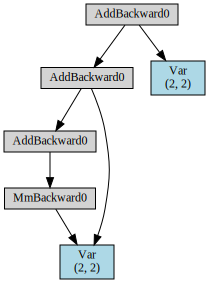

In [59]:
make_vizualization_autograd(f)

#### Questions
- En considérant que `Add` réfère à une addition matricielle et `Mm` à une multiplication matricielle, associez chaque rectangle bleu du graphe au `Tensor` ($x$, $y$ ou $z$) correspondant.

- Que devient le graphe si on change `x.requires_grad=True`? Effectuez le changement dans le code pour confirmer votre réponse.

Effectuons maintenant la backprop du gradient. Au départ les attributs `grad` des `Tensor` sont vides.

In [60]:
print(x.grad)
print(y.grad)
print(z.grad)

None
None
None


On appele la fonction `backward`.

In [61]:
f.backward(torch.ones(f.size()))

Et on obtient des valeurs de gradients pour les `Tensor` qui avaient `requires_grad=True`, par conséquent `x.grad` devrait toujours être vide.

In [62]:
print(x.grad)
print(y.grad)
print(z.grad)

None
tensor([[1.3300, 1.3300],
        [2.2460, 2.2460]])
tensor([[1., 1.],
        [1., 1.]])


#### Questions
- Exécutez deux fois la cellule qui appelle la fonction .backward(). Qu'arrive-t-il? Pourquoi? Ça casse car on a pas effectué la phase d'update qui vide ensuite le gradient.

- Quel `Tensor` auraient requires_grad=False dans le contexte d'entraînement de réseaux de neurones? le tensor contenant les données en entrée du réseau de neurones

Il est possible de prévenir l'enregistrement de l'historique de calcul d'opérations effectuées sur des `Tensor` aillant `requires_grad=True` en utilisant un bloc de code avec `with torch.no_grad()`:

In [63]:
print((y + z).requires_grad)

with torch.no_grad():
    print((y + z).requires_grad)

True
False


#### Exercice
- Faites la mise à jour des valeurs de y et z et soustrayant leur gradient multiplié par $1 \times 10^{-3}$  sans créer un nouveau graphe de calcul lors de l'opération. Notez que si le tenseur résultant a un attribut `grad_fn`, un graphe de calcul a été créé.

In [64]:
y = torch.randn((2, 2), requires_grad=True)
z = torch.randn((2, 2), requires_grad=True)

f = torch.matmul(y, z)
f.backward(torch.ones(f.size()))

# TODO Mise à jour de y et z
with torch.no_grad():
  y = y - y.grad * 1e-3
  z = z - z.grad * 1e-3

print(y)
print(z)

tensor([[-1.4633, -1.6612],
        [-0.9360,  1.0328]])
tensor([[ 0.0577,  0.1340],
        [-0.7667,  1.1867]])


#### Question
- Dans le contexte des réseaux de neurones, dans quelle situation voudrait-on ne calculer aucun gradient d'un graphe de calcul? Lors de l'inférence, c'est-à-dire lors de l'utilisation du réseau plutôt que lors de l'entraînement.

### Descente du gradient: un aperçu
Considérons une fonction simple en une dimension:
$$ f(x) = x^2 - x + 2 $$

In [65]:
def fonction_simple(x):
    return x**2 - x + 2

On peut visualiser cette fonction convexe qui possède un minimum global en $x = 0.5$

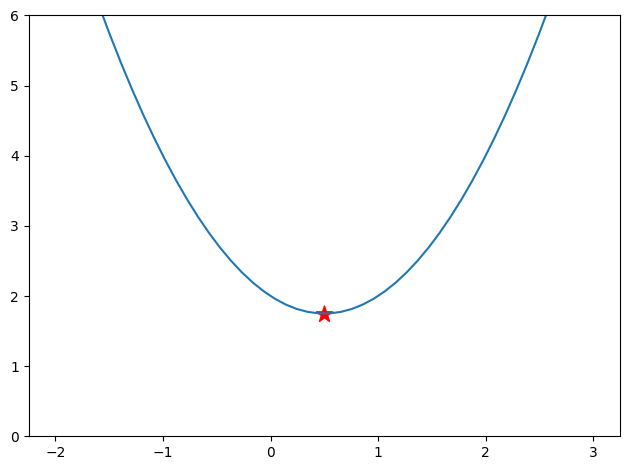

In [66]:
x_range = np.linspace(-2, 3)
plt.plot(x_range, fonction_simple(x_range) )
plt.scatter(.5, fonction_simple(.5), s=150, marker='*', c='r')
plt.ylim(0, 6)
plt.tight_layout()
plt.show()

Nous allons tenter de trouver ce minimum global en partant avec $x = -2$ par la méthode de descente du gradient (vu en détails au prochain cours) en utilisant la dérivation automatique de PyTorch. À chaque itération, la fonction est évaluée au paramètre $x$, le gradient est obtenu en appelant `backward`, puis la valeur du paramètre `x` est mise à jour selon la direction pointée par le gradient et un certain pas (0.25 dans cet exemple).

#### Exercice
- Dans son état actuel, le code ne permet pas de converger vers le minimum global. Une étape est manquante dans la boucle de descente du gradient concernant le graphe de calcul. Ajoutez la ligne manquante et confirmez que le paramètre $x$ converge bien vers le minimum global. **Indice: observez les valeurs de f'(x) au fil des itérations. Est-ce que les valeurs correspondent aux gradients attendus?**.

In [4]:
# Nombre d'itérations
T = 10

# Initialisation
x = torch.Tensor([-2])
x.requires_grad = True
list_x, list_values = [], []

# Boucle de descente du gradient
for t in range(T):

    # Calcul de la fonction objectif
    val = fonction_simple(x)

    # Enregistrement des valeurs pour visualisation
    list_x.append(np.array(x.detach()))
    list_values.append(val.detach())

    # Calcul des gradients
    val.backward()

    print(f"Iteration {t+1:02}:",
          f" x ={x.item(): .5f}",
          f" f(x) ={val.item(): .5f}",
          f" f\'(x) ={x.grad.item(): .5f}")

    # Mise à jour du paramètre x
    with torch.no_grad():
        x -= 0.25 * x.grad

    # TODO Ajoutez l'étape manquante
    x.grad.zero_()

plt.plot(x_range, fonction_simple(x_range))
plt.plot(list_x, list_values, linestyle='dashed', marker='o', color='green')
plt.scatter(.5, fonction_simple(.5), s=150, marker='*', c='r')
plt.show()

NameError: name 'fonction_simple' is not defined

## Partie 2: Fonctions d'activation

La section suivante a pour but d'explorer les différences entre les fonctions d'activation ReLU et Tanh.

#### Question préalable
- À quoi sert la fonction d'activation? Sans elle, que devient un réseau multi-couches? Il devient une simple couche linéaire (effondrement linéaire)

### Visualisation du dataset
Pour cette partie, nous utiliserons le dataset binaire des spirales. Chaque exemple est représenté par un vecteur de dimension 7: $[x, y, x^2, y^2, x*y, \sin(x), \sin(y)]$, où les deux premières valeurs correspondent aux coordonnées dans un espace en deux dimensions présenté par le graphique suivant, et les autres valeurs sont des transformations sur les deux premières. Vous pouvez voir le code qui a servi à générer le dataset dans la librairie https://github.com/ulaval-damas/glo4030-labs/blob/master/deeplib/datasets.py

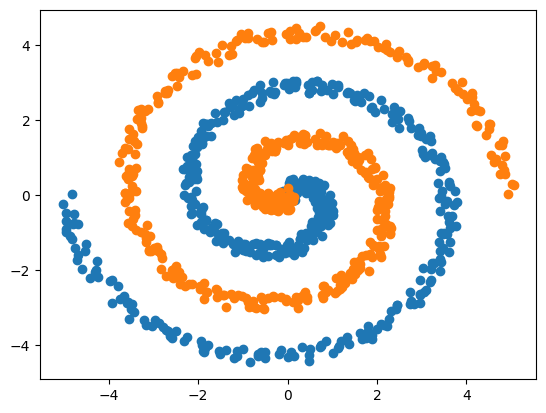

In [5]:
from deeplib.datasets import SpiralDataset, train_valid_loaders
import random

random.seed(42)
dataset = SpiralDataset()
points, labels = dataset.to_numpy()
plt.scatter(points[labels==1,0], points[labels==1,1])
plt.scatter(points[labels==0,0], points[labels==0,1])
plt.show()

### Création de modèles

Ici, on crée des classes qui héritent de `torch.nn.Module`. C'est la classe de base de tout réseau dans PyTorch. `Module` comporte par exemple la méthode `named_parameters()` qui permet d'obtenir toutes les variables entraînables du `Module` ainsi que leur nom. Voici un lien vers la documentation complète:
http://pytorch.org/docs/stable/nn.html#torch.nn.Module.

#### Exercice
- Complétez la fonction forward de TanhModel et ReluModel en appliquant à chaque couche la transformation linéaire ([Indice](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)) suivie de la fonction activation ([Indice](https://pytorch.org/docs/stable/generated/torch.tanh.html?highlight=tanh#torch.tanh)).


In [6]:
class RandomModel(torch.nn.Module):

    def __init__(self, n_layers, init_gaussian_mean):
        super().__init__()
        # Le modèle Tanh et ReLU vont être initialisé avec les mêmes matrices aléatoires
        torch.manual_seed(42)

        # Initialisation des couches
        self.layers = []
        for i in range(n_layers):
            layer = nn.Linear(7,7)
            layer.weight.data.normal_(init_gaussian_mean, math.sqrt(2 / 7))
            layer.bias.data.fill_(0)
            self.layers.append(layer)
            self.add_module('layer-%d' % i, layer)
        self.output_layer = nn.Linear(7,2)

        self.nonzero_grad_stats = None

    def forward(self):
        raise NotImplementedError('Defined in children classes')

    def _forward_output_layer(self, x):
        # Couche de sortie avec une neurone par classe
        out = self.output_layer(x)
        out = F.log_softmax(out, dim=1)
        return out

    def compute_gradients_stats(self):
        self.nonzero_grad_stats = []

        # Calcul pour chaque couche du nombre de poids avec un gradient non nul
        # ainsi que la moyenne de ces derniers.
        for i, layer in enumerate(self.layers):
            if layer.weight.grad is not None:
                nonzero_grad_indices = torch.nonzero(layer.weight.grad)
                nonzero_grad = [layer.weight.grad.data[i,j] for (i,j) in nonzero_grad_indices]
                nonzero_grad_mean = np.mean(np.abs(nonzero_grad)) if nonzero_grad else 0
                self.nonzero_grad_stats.append((len(nonzero_grad), nonzero_grad_mean))

class RandomTanhModel(RandomModel):

    def __init__(self, n_layers, init_gaussian_mean=0.0):
        super().__init__(n_layers, init_gaussian_mean)

    def forward(self, x):
        out = x
        for layer in self.layers:
            # TODO
            out = layer(out)
            out = torch.tanh(out)

        return self._forward_output_layer(out)

class RandomReluModel(RandomModel):

    def __init__(self, n_layers, init_gaussian_mean=0.0):
        super().__init__(n_layers, init_gaussian_mean)

    def forward(self, x):
        out = x
        for layer in self.layers:
            # TODO
            out = layer(out)
            out = F.relu(out)
        return self._forward_output_layer(out)

### Analyse du modèle

In [24]:
# Dataloaders
train_loader, valid_loader = train_valid_loaders(dataset, 50)

# Paramètres
init_gaussian_mean = 0.5
n_layers = 10

# Modèles
relu_model = RandomReluModel(n_layers, init_gaussian_mean)
tanh_model = RandomTanhModel(n_layers, init_gaussian_mean)

# Forward pass
data, labels = next(iter(train_loader))
relu_output = relu_model(data)
tanh_output = tanh_model(data)

# Calcul de la perte
loss = torch.nn.NLLLoss()
relu_loss = loss(relu_output, labels)
tanh_loss = loss(tanh_output, labels)

# Backward
relu_loss.backward()
tanh_loss.backward()

# Calcul des statistiques des gradients
relu_model.compute_gradients_stats()
tanh_model.compute_gradients_stats()

Le graphique suivant représente en fonction du numéro de la couche à gauche la quantité de poids qui ont un gradient nul lors de la backprop, et à droite le gradient moyen sans tenir compte des gradients nuls.

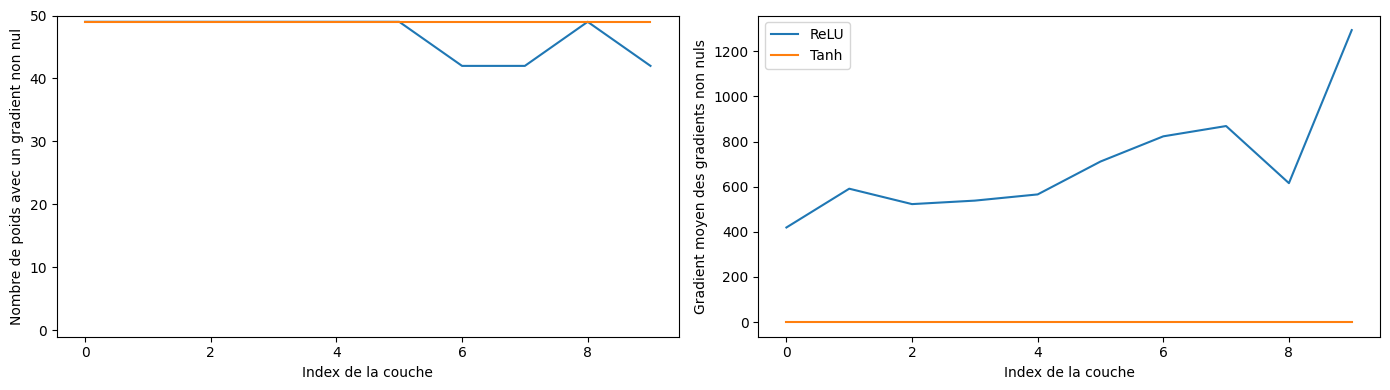

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(14,4))
axs[0].plot(np.arange(len(relu_model.nonzero_grad_stats)), [x[0] for x in relu_model.nonzero_grad_stats], label='ReLU')
axs[0].plot(np.arange(len(tanh_model.nonzero_grad_stats)), [x[0] for x in tanh_model.nonzero_grad_stats], label='Tanh')
axs[0].set_ylim([-1, 50])
axs[0].set_xlabel('Index de la couche')
axs[0].set_ylabel('Nombre de poids avec un gradient non nul')
axs[1].plot(np.arange(len(relu_model.nonzero_grad_stats)), [x[1] / x[0] if x[0] else 0 for x in relu_model.nonzero_grad_stats],label='ReLU')
axs[1].plot(np.arange(len(tanh_model.nonzero_grad_stats)), [x[1] / x[0] if x[0] else 0 for x in tanh_model.nonzero_grad_stats],label='Tanh')
axs[1].set_xlabel('Index de la couche')
axs[1].set_ylabel('Gradient moyen des gradients non nuls')
axs[1].legend()
plt.tight_layout()
plt.show()

#### Questions
- Observez la distribution du gradient lors de la backprop. Quelles différences y a-t-il entre l'utilisation des activations ReLU versus Tanh? La fonction relu cause beaucoup de gradient nul, toutefois la tanh a de la difficulté à conserver une valeur de gradient non-nul.

- Suite à ces observations, identifiez un problème avec la Relu et identifiez un problème avec la Tanh. Relu: mort de neurones. Tanh problème de vanishing gradient.

- Changez la moyenne de la gaussienne des poids lors de l'initialisation (le paramètre *init_gaussian_mean*). Qu'observez-vous?

- Est-ce que, pour deux entrées différentes, les mêmes poids ont un gradient nul?

### Entraînement
Pour terminer, on entraîne les deux modèles avec des fonctions d'activation différentes sur le dataset des spirales.

In [15]:
from torch.optim import SGD

init_gaussian_mean = 0
n_layers = 10
n_epoch = 500
relu_losses = []
tanh_losses = []

relu_model = RandomReluModel(n_layers, init_gaussian_mean)
tanh_model = RandomTanhModel(n_layers, init_gaussian_mean)

if torch.cuda.is_available():
    relu_model.cuda()
    tanh_model.cuda()

relu_optimizer = SGD(relu_model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
tanh_optimizer = SGD(tanh_model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

for epoch in range(1, n_epoch + 1):
    if epoch % 100 == 0:
        print("Epoch %d done." % epoch)
    relu_epoch_losses = []
    tanh_epoch_losses = []
    for data, labels in train_loader:
        relu_optimizer.zero_grad()
        tanh_optimizer.zero_grad()

        if torch.cuda.is_available():
            data = data.cuda()
            labels = labels.cuda()

        relu_loss = loss(relu_model(data), labels)
        tanh_loss = loss(tanh_model(data), labels)

        relu_loss.backward()
        tanh_loss.backward()

        relu_epoch_losses.append(float(relu_loss.cpu()))
        tanh_epoch_losses.append(float(tanh_loss.cpu()))

        relu_optimizer.step()
        tanh_optimizer.step()
    relu_losses.append(np.mean(np.asarray(relu_epoch_losses)))
    tanh_losses.append(np.mean(np.asarray(tanh_epoch_losses)))

/tmp/ipython-input-1356230576.py:38: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  relu_epoch_losses.append(float(relu_loss.cpu()))


Epoch 100 done.
Epoch 200 done.
Epoch 300 done.
Epoch 400 done.
Epoch 500 done.


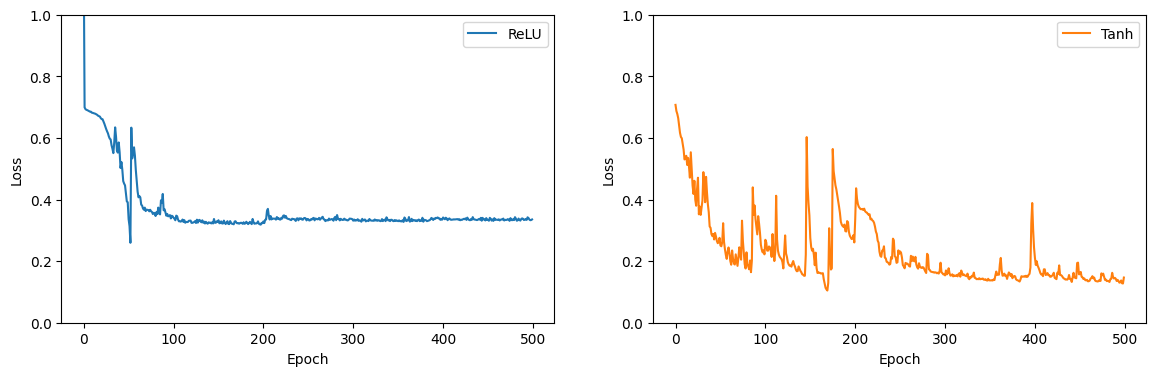

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(14,4))
axs[0].plot(np.arange(len(relu_losses)), np.asarray(relu_losses),label='ReLU', color='tab:blue')
axs[1].plot(np.arange(len(tanh_losses)), np.asarray(tanh_losses),label='Tanh', color='tab:orange')
for i in range(2):
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_ylim(0, 1)
    axs[i].legend()
plt.show()

## Perte d'entropie croisée (Cross-entropy loss) dans PyTorch

**Important à savoir lorsqu'on utilise PyTorch pour un problème de classification**: Dans un contexte de tâche de classification, il est d'usage de transformer les sorties réelles d'un réseau de neurones en une distribution de probabilité sur les classes grâce à la fonction [Softmax](https://pytorch.org/docs/master/generated/torch.nn.Softmax.html?#torch.nn.Softmax). Cette distribution peut ensuite être utilisée pour prédire le ou les classes les plus probables selon la donnée en entrée.

Voici un exemple de l'utilisation de la fonction ``F.softmax``, vous pouvez modifier les valeurs de sorties pour voir l'impact sur la distribution de probabilité résultante.

In [22]:
sorties = torch.tensor([4.0, 5.0, -2.0])
F.softmax(sorties, dim=-1)

tensor([2.6876e-01, 7.3057e-01, 6.6620e-04])

Afin d'entraîner un réseau de neurones pour une tâche de classification, on utilise habituellement la fonction de perte d'entropie croisée  [CrossEntropyLoss](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html?#torch.nn.CrossEntropyLoss) qui combine la fonction de [LogSoftmax](https://pytorch.org/docs/master/generated/torch.nn.LogSoftmax.html?#torch.nn.LogSoftmax) avec la fonction de perte *negative log likelihood* [NLLLoss](https://pytorch.org/docs/master/generated/torch.nn.NLLLoss.html?#torch.nn.NLLLoss). La fonction [LogSoftmax](https://pytorch.org/docs/master/generated/torch.nn.LogSoftmax.html?#torch.nn.LogSoftmax) est utilisée au lieu de la fonction [Softmax](https://pytorch.org/docs/master/generated/torch.nn.Softmax.html?#torch.nn.Softmax) pour des raisons de stabilité numérique et de rapidité de calcul.

Pour l'entraînement du modèle plus haut dans ce laboratoire, la fonction de perte d'entropie croisée a été calculée en deux étapes avec ``F.log_softmax`` dans la fonction ``_forward_output_layer(x)`` du ``RandomModel``, suivie du calcul de la perte selon les étiquettes avec la fonction ``loss`` définie par ``torch.nn.NLLLoss()``.

Pour utiliser directement ``torch.nn.CrossEntropyLoss()``, le modèle devrait retourner simplement les valeurs réelles de sortie sans appliquer de fonction ``Softmax`` ou ``LogSoftmax``. Le résultat de perte est identique dans les deux cas comme le démontre la prochaine cellule:

In [23]:
# Scores d'un réseau de neurones pour 2 exemples d'une tâche à 3 classes avec les étiquettes correspondantes
scores = torch.tensor([[1.7, 1.4, -1.3], [0.4, 1.8, 0.9]])
labels = torch.tensor([0, 2])

# CrossEntropyLoss
loss = torch.nn.CrossEntropyLoss()
print(f"Perte avec CrossEntropyLoss: {loss(scores, labels):.3f}")

# LogSoftmax et NLLLoss
loss = torch.nn.NLLLoss()
print(f"Perte avec LogSoftmax et NLLLoss: {loss(F.log_softmax(scores, dim=1), labels):.3f}")

Perte avec CrossEntropyLoss: 0.993
Perte avec LogSoftmax et NLLLoss: 0.993


Dans la librairie deeplib écrite spécialement pour les laboratoires, la fonction ``deeplib.training.train()`` utilise par défaut ``torch.nn.CrossEntropyLoss()``. Par conséquent, les modèles doivent simplement retourner les sorties réelles du réseau de neurones pour pouvoir s'entraîner correctement avec cette fonction ``train()``.